# PyTorch tutorial
Creating a neural network that classifies clothes.

## Import necessary packages

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Choose device
Choosing device to create and do tensor operations on.

Note: As I am using a MacBook with Apple Silicon (M1), I could use MPS by running `device = torch.device("mps")`. However, I wasn't able to do that without getting an error.

In [2]:
device = torch.device("cpu")

print("Using {} device".format(device))

Using cpu device


## Loading in training and test data

In [3]:
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

## Creating the neural network

In [4]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Move the neural network to the chosen device (CPU) so that it runs on it.

In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Define hyperparameters, loss function and optimizer

In [6]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 10

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Defining training and test loops

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):

        # Forward pass
        pred = model(X)

        # Calculate loss
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Turning off computation of gradients to save time and resources
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Training the neural network

In [8]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(train_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.309688  [   64/60000]
loss: 2.297307  [ 6464/60000]
loss: 2.275357  [12864/60000]
loss: 2.268315  [19264/60000]
loss: 2.255909  [25664/60000]
loss: 2.223030  [32064/60000]
loss: 2.227890  [38464/60000]
loss: 2.191206  [44864/60000]
loss: 2.190244  [51264/60000]
loss: 2.171085  [57664/60000]
Test Error: 
 Accuracy: 43.2%, Avg loss: 2.158297 

Epoch 2
-------------------------------
loss: 2.166908  [   64/60000]
loss: 2.154979  [ 6464/60000]
loss: 2.097145  [12864/60000]
loss: 2.122173  [19264/60000]
loss: 2.065628  [25664/60000]
loss: 2.008320  [32064/60000]
loss: 2.035943  [38464/60000]
loss: 1.950788  [44864/60000]
loss: 1.963790  [51264/60000]
loss: 1.910126  [57664/60000]
Test Error: 
 Accuracy: 53.5%, Avg loss: 1.893913 

Epoch 3
-------------------------------
loss: 1.920587  [   64/60000]
loss: 1.893254  [ 6464/60000]
loss: 1.772014  [12864/60000]
loss: 1.831459  [19264/60000]
loss: 1.707569  [25664/60000]
loss: 1.661944  [32064/600

## Making some predictions with the trained network

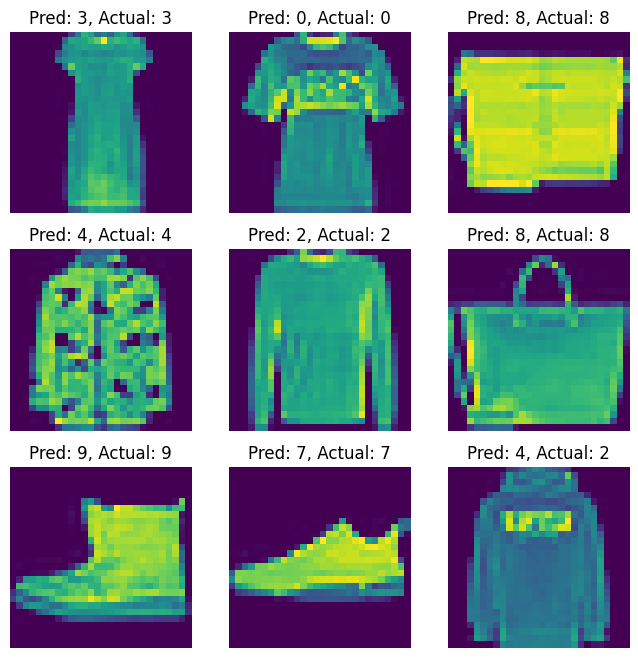

In [9]:
model.eval()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataloader.dataset), size=(1,)).item()
    img, label = training_data[sample_idx]
    
    with torch.no_grad():
        pred = model(img)
        pred_class = pred.argmax(1).item()
    
    figure.add_subplot(rows, cols, i)

    plt.title(f"Pred: {pred_class}, Actual: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()